In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
# These modules are used for animating some oåf the graphs in our notebook.
from matplotlib import animation, rc
from IPython.display import HTML

from hcipy import atmosphere
from hcipy import fourier
import matplotlib as mpl

%matplotlib inline

In [2]:
import sim_sparkle as smsp
reload(smsp)

<module 'sim_sparkle' from '/home/eden/code/sparkles/sim/sim_sparkle.py'>

### Jared's way or the highway

Created: 11/01/2023

we're doing direct reconstruction because this really really should work. 

### Basic AO Setup

In [3]:
# creating the grids across which the pupils etc are defined
pupil_grid, pwfs_grid, magellan_aperture = smsp.create_mag_pupil()
# creating a modulated pywfs
mpwfs, camera = smsp.create_mod_PWFS(pupil_grid, pwfs_grid, n_steps=10)

In [4]:
# wavefront generation 
#NEW CODE : supersample evaluation
wf = smsp.create_wf(magellan_aperture)
wfs_pywfs = smsp.create_pwfs(mpwfs, wf)
#creating an image refernce to use later
image_ref = smsp.mod_forward_int(wfs_pywfs)

### Normed Zernike slopes demo

In [5]:
# NO MORE INTERACTION MATRICES >:(
def dumb_zernikes(zern_slopes, wfs_image, mode):
    zern_coeff_dumb = np.sum(zern_slopes[mode,:]*wfs_image)
    return zern_coeff_dumb

In [6]:
n_z_modes = 50
#create the zernike mode DM
zern_dm_norm = smsp.create_DM_zern(pupil_grid, n_z_modes, magellan_aperture)

In [7]:
# creting an interaction matrix
z_slopes_norm = smsp.create_int_mat_mod_normed(zern_dm_norm, wf, mpwfs) #careful from surface to OPD translation

Measure response to mode 1 / 50
Measure response to mode 11 / 50
Measure response to mode 21 / 50
Measure response to mode 31 / 50
Measure response to mode 41 / 50


In [14]:
# ITER ON ZERNIKES - NON RESIDUALS - DUMBBB
# mode iterations
mode_index = np.array([0, 10, 40])
amplitudes = np.linspace(0, 750e-9, 51)
num_iterations = 10
# Non residual iterations
wf = smsp.create_wf(magellan_aperture)
coeffs_dumb = np.zeros((mode_index.size, amplitudes.size)) #coeffs without additional aberrations
# iterating in detail over amplitudes to see behavior
for mi, mode in enumerate(mode_index):
    print(f"MODE: {mode}")
    for ai, amp in enumerate(amplitudes):
        zern_dm_norm.flatten()
        zern_dm_norm.actuators[mode] = amp # rms put in get twice back
        # propagate through the AO system
        wf_zern = zern_dm_norm.forward(wf)
        phase = wf_zern.phase
        wf_pyr = mpwfs.forward(wf_zern)
        # difference between what we have and what we expect
        wfs_image = smsp.mod_forward_int(wf_pyr)
        diff_image = wfs_image - image_ref
        # Use Coeffs on the reconstruction to see differences
        cf_dumb = dumb_zernikes(z_slopes_norm, diff_image, mode)
        # adding to the 
        coeffs_dumb[mi, ai] = cf_dumb

MODE: 0
MODE: 10
MODE: 40


In [23]:
coeffs_dumb

array([[0.00000000e+00, 2.75979286e-11, 4.42932916e-11, 4.52683257e-11,
        3.43170493e-11, 2.14094305e-11, 1.68586008e-11, 2.56184863e-11,
        4.50176512e-11, 6.70309090e-11, 8.34224528e-11, 9.04824492e-11,
        9.05598349e-11, 8.97626278e-11, 9.36131953e-11, 1.03583558e-10,
        1.16651148e-10, 1.27915934e-10, 1.34320671e-10, 1.36898910e-10,
        1.40072309e-10, 1.48540192e-10, 1.63896268e-10, 1.83249076e-10,
        2.00771986e-10, 2.11189661e-10, 2.12976845e-10, 2.09268581e-10,
        2.05964072e-10, 2.08260793e-10, 2.17765067e-10, 2.31862886e-10,
        2.45564178e-10, 2.54530130e-10, 2.57389556e-10, 2.56052868e-10,
        2.54070721e-10, 2.54265849e-10, 2.57171293e-10, 2.61129897e-10,
        2.63771260e-10, 2.63747748e-10, 2.61578361e-10, 2.59155746e-10,
        2.58387204e-10, 2.59953208e-10, 2.62986360e-10, 2.65788353e-10,
        2.67011183e-10, 2.66484188e-10, 2.65185686e-10],
       [0.00000000e+00, 2.29645660e-10, 4.48568170e-10, 6.49795314e-10,
       

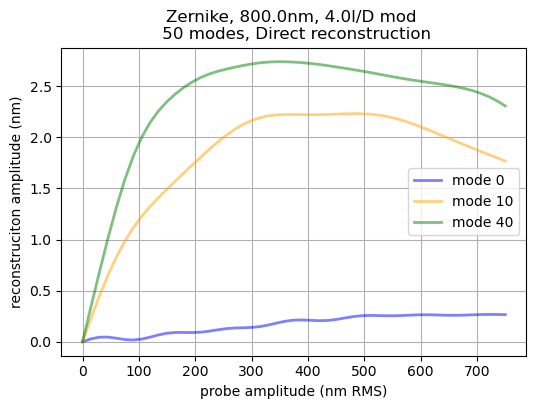

In [26]:
# plotting the difference from previous reconstructed matrix to ours
colors = ['blue', 'orange', 'green']

fig = plt.figure(figsize=(6,4))
plt.grid()

#plt.plot(amplitudes/1e-9, amplitudes/1e-9, alpha=0.5, color = "black", label = "perfect reconstruction")
for e, mode in enumerate(mode_index):
    plt.plot(amplitudes/1e-9, coeffs_dumb[e,:]/1e-9, color = colors[e], lw=2, label = f'mode {mode}', alpha=0.5)

#plt.ylim([0,4e-7])
plt.xlabel("probe amplitude (nm RMS)")
plt.ylabel("reconstruciton amplitude (nm)")
plt.title(f"Zernike, {np.round(smsp.wavelength_wfs/1e-9,3)}nm, {smsp.modulation/smsp.spatial_resolution}l/D mod \n 50 modes, Direct reconstruction")
plt.legend()